In [37]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as pimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import random
%matplotlib inline

In [2]:
train_horse_dir = 'train_dir/horses'
train_humans_dir = 'train_dir/humans'

In [3]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_humans_names = os.listdir(train_humans_dir)
print(train_humans_names[:10])

['horse12-6.png', 'horse24-7.png', 'horse21-4.png', 'horse45-5.png', 'horse36-0.png', 'horse45-4.png', 'horse03-8.png', 'horse47-4.png', 'horse35-4.png', 'horse24-6.png']
['human01-00.png', 'human08-18.png', 'human15-15.png', 'human02-25.png', 'human04-21.png', 'human05-21.png', 'human05-08.png', 'human12-04.png', 'human10-08.png', 'human04-24.png']


In [4]:
train_horse_names[0]

'horse12-6.png'

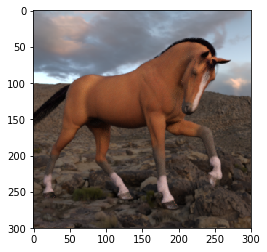

In [5]:
plt.imshow(pimg.imread(train_horse_dir + '/' + train_horse_names[0]))

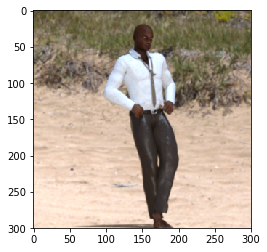

In [6]:
plt.imshow(pimg.imread(train_humans_dir + '/' + train_humans_names[12]))

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 33, 33, 64)       

In [19]:
model.compile(loss='binary_crossentropy',
             optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
             metrics=['acc'])

In [20]:
len(os.listdir(train_horse_dir))

500

In [21]:
train_datagen = ImageDataGenerator(rescale = 1/255)
train_gen = train_datagen.flow_from_directory(
    'train_dir',
    target_size = (300, 300),
    batch_size = 32,
    class_mode = 'binary'
)

Found 1027 images belonging to 2 classes.


In [22]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch = 32,
    epochs = 8,
    verbose = 1
)

Epoch 1/8
32/32 [==============================] - 45s 1s/step - loss: 0.7059 - acc: 0.6080
Epoch 2/8
32/32 [==============================] - 46s 1s/step - loss: 0.3463 - acc: 0.8804
Epoch 3/8
32/32 [==============================] - 47s 1s/step - loss: 0.1509 - acc: 0.9477
Epoch 4/8
32/32 [==============================] - 49s 2s/step - loss: 0.1789 - acc: 0.9453
Epoch 5/8
32/32 [==============================] - 44s 1s/step - loss: 0.1527 - acc: 0.9607
Epoch 6/8
32/32 [==============================] - 47s 1s/step - loss: 0.1053 - acc: 0.9678
Epoch 7/8
32/32 [==============================] - 47s 1s/step - loss: 0.0326 - acc: 0.9928
Epoch 8/8
32/32 [==============================] - 49s 2s/step - loss: 0.0394 - acc: 0.9854


In [23]:
model.layers

In [26]:
outputs = [layer.output for layer in model.layers]

In [27]:
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = outputs)

In [47]:
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_humans_dir, f) for f in train_humans_names]
img_path = random.choice(horse_img_files + human_img_files)

In [48]:
img = load_img(img_path, target_size=(300, 300))
x = img_to_array(img)

In [49]:
x = x.reshape((1, ) + x.shape) # Reshape to (1, 150, 150, 3)
x /= 255 # Rescaling

In [50]:
successive_feature_maps = visualization_model.predict(x)

In [51]:
layer_names = [layer.name for layer in model.layers]

/home/sahilsharma/venv/ml/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


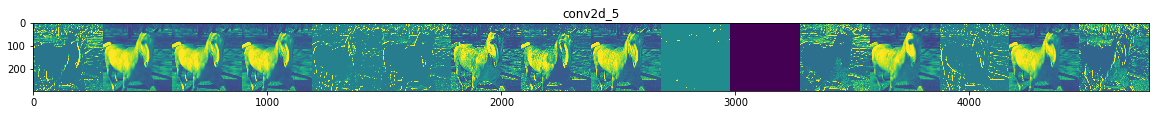

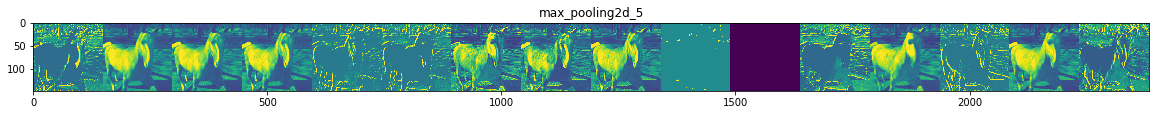

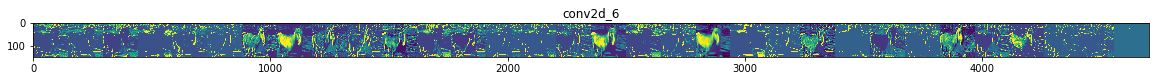

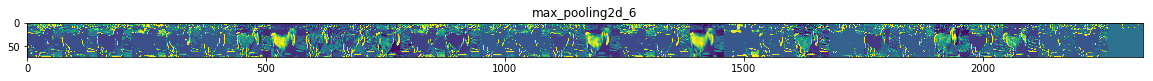

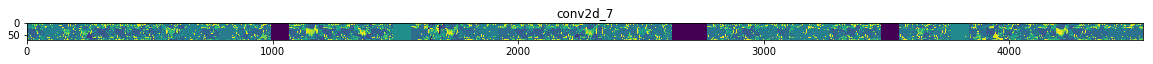

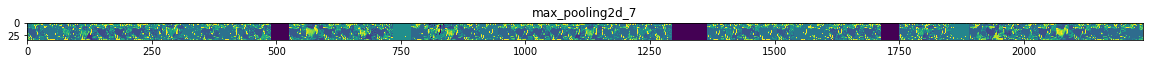

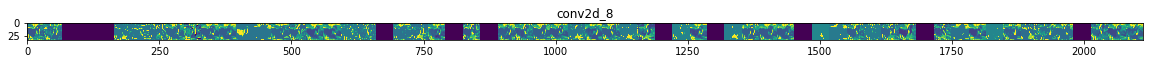

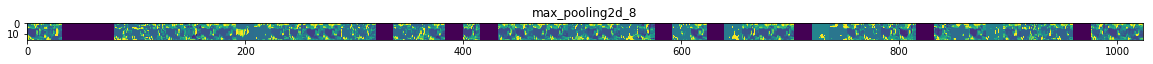

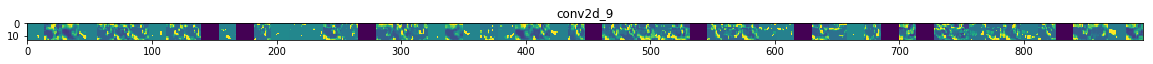

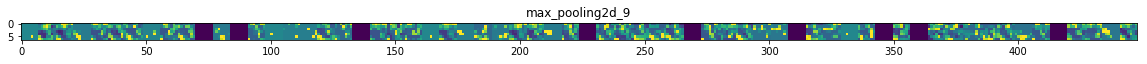

In [55]:
# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')